First lets load required modules and seed the random number generators to make results reproducible:

In [40]:
import datetime
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.callbacks import TensorBoard
import numpy as np
import os
import random as rn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

rn.seed(42)
np.random.seed(42)

Load training data:

In [41]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
# https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation

Seems ok.

Scale and cast data:

In [42]:
# Cast:
train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

# Scale:
scaler = StandardScaler(with_mean=True, with_std=True)
train_images = scaler.fit_transform(train_images.reshape((60000, 784))).reshape((60000, 28, 28))
test_images = scaler.transform(test_images.reshape((10000, 784))).reshape((10000, 28, 28))

Get some validation data:

In [43]:
from sklearn.model_selection import train_test_split
validation_images, test_images, validation_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

Checking that training, validation and test dataset is shufled.

In [47]:
print(train_labels[0:20])
print(validation_labels[0:20])
print(test_labels[0:20])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
[8 4 3 1 2 9 0 5 8 7 7 7 5 7 6 1 1 3 2 7]
[6 2 3 7 2 2 3 4 7 6 6 9 2 0 9 6 8 0 6 5]


Plotting a few of the training images:

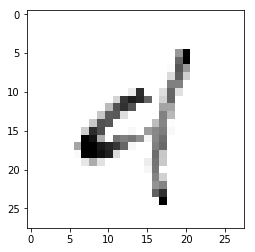

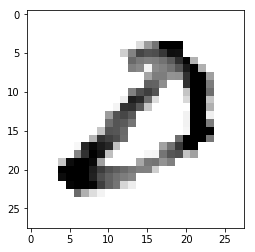

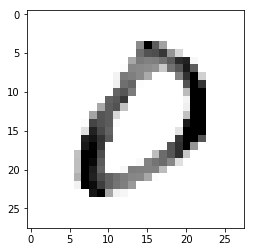

In [45]:
for i in np.random.choice(len(train_images), 3):
    plt.imshow(train_images[i], cmap="Greys", vmin=0, vmax=2)
    plt.show()

Lets define a helper function that fits, visualizes and stores trained models:

In [48]:
def fit_and_save_model(name, model, X_train, y_train, X_validation, y_validation,
                       epochs = 5, batch_size=64, validation_split = 1.0/12, eval_batch_size=128):
    required_folders = './output/{}/logs/'.format(name)
    if not os.path.exists(required_folders):
        os.makedirs(required_folders)

    # Validation data is not shuffled! This is probably a problem!
    tensorboard = TensorBoard('./output/{}/logs/{}'.format(name, datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")))
    history = model.fit(X_train, to_categorical(y_train), 
                        validation_split=validation_split, 
                        epochs=epochs,
                        batch_size=batch_size, 
                        verbose=1, 
                        callbacks=[tensorboard])

    score = model.evaluate(X_validation, to_categorical(y_validation))
    with open("./output/{}/{}.score".format(name, name), 'w+') as f:
        f.write("Validation loss: {}\n".format(score[0]))
        f.write("Validation accuracy: {}".format(score[1]))
        
    model.save('./output/{}/{}.h5'.format(name, name))
    with open("./output/{}/{}.json".format(name, name), 'w+') as f:
        f.write(model.to_json())
    
    plt.plot(history.history['loss'], label='Training data loss')
    plt.plot(history.history['val_loss'], label='Validation data loss')
    plt.legend()
    plt.title("Model {} loss".format(name))
    plt.savefig('./output/{}/model_{}_loss.png'.format(name,name))
    plt.show()

    plt.plot(history.history['acc'], label='Training data accuracy')
    plt.plot(history.history['val_acc'], label='Validation data accuracy')
    plt.legend()
    plt.title("Model {} accuracy".format(name))
    plt.savefig('./output/{}/model_{}_accuracy.png'.format(name,name))
    plt.show()

Now create and train a simple sequential model without any regularization:

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 4s 74us/step - loss: 0.9134 - acc: 0.7929 - val_loss: 0.4597 - val_acc: 0.8984
Epoch 2/5
55000/55000 [==============================] - 4s 70us/step - loss: 0.4638 - acc: 0.8807 - val_loss: 0.3418 - val_acc: 0.9148
Epoch 3/5
55000/55000 [==============================] - 4s 71us/step - loss: 0.3881 - acc: 0.8942 - val_loss: 0.2988 - val_acc: 0.9194
Epoch 4/5
55000/55000 [==============================] - 4s 75us/step - loss: 0.3527 - acc: 0.9009 - val_loss: 0.2758 - val_acc: 0.9250
Epoch 5/5
55000/55000 [==============================] - 4s 71us/step - loss: 0.3317 - acc: 0.9059 - val_loss: 0.2588 - val_acc: 0.9294


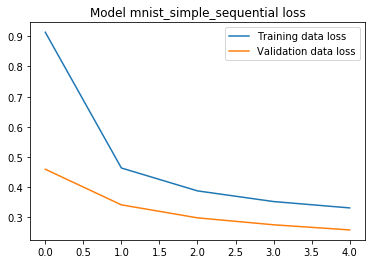

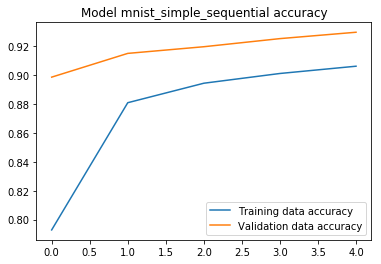

5000/5000 [==============================] - 0s 60us/step


In [54]:
simple_sequential = Sequential()
simple_sequential.add(Flatten(input_shape=(28,28)))
simple_sequential.add(Dense(1000, activation='sigmoid'))
simple_sequential.add(Dense(10, activation='softmax'))
simple_sequential.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])
fit_and_save_model("mnist_simple_sequential", simple_sequential, 
                   train_images, train_labels, validation_images, validation_labels)

Now lets try the same model with regularisation:

In [ ]:
simple_sequential = Sequential()
simple_sequential.add(Flatten(input_shape=(28,28)))
simple_sequential.add(Dense(1000, activation='sigmoid', kernel_regularizer=l2(0.01)))
simple_sequential.add(Dense(10, activation='softmax'))
simple_sequential.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])
fit_and_save_model("mnist_simple_sequential_L2", simple_sequential, 
                   train_images, train_labels, validation_images, validation_labels)

Lets try a simple convolutional neural network:

In [ ]:
simple_convolutional = Sequential()
simple_convolutional.add(Reshape((28,28,1), input_shape=(784,)))
simple_convolutional.add(Conv2D(50, 
                 kernel_size=3, 
                 activation="relu"))
#simple_convolutional.add(Dropout(rate=0.1))
simple_convolutional.add(Conv2D(100, 
                  kernel_size=3, 
                  activation='relu'))
simple_convolutional.add(Dense(10, activation='softmax'))
simple_convolutional.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
fit_and_save_model("mnist_convolutional", simple_convolutional,
                   train_images, train_labels, validation_images, validation_labels,
                   batch_size=int(len(X_train)*0.001), epochs=3)

In [ ]:
# Tasks: Experiment with different hyperparameter settings (e.g. learning rate, early stopping, batch sizes, etc)
# and observe their effects on training time, overfitting, and final accuracy.
# See if L2 regularisation has effect on network using relu activation function.
# Compare contrast with relu + dropout.